# fastai 2022 - week 1

```
# "fastai 2022 - week 1 - Private CV"
> "Small project starting to see if I can make CV private for my smart home use case"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Craig Stanton
- categories: [fastai]
```

## Private CV - Mini project outline

Can CV be "private"\*? Or asked another way, how much "detail" do we need to give a model in order to get the output we want (in this case, a simple multi-class classification)?

If we can show, for example, that an 8-bit-style image is sufficient to achieve out outcome, can we use extremely small models that use significantly less energy (and are thus better suited for battery-operated smart home devices) while also being respectful of privacy?

Whatever the outcome, the answers to this problem will help me discect DL models in far greater detail than I have have done in the past. 

\* In this definition borrowed from OpenMined, privacy means plausible deniability. In the case of a smart home camera, this would mean that the model would detect that someone was present in the room but a nefarious actor could never generate accurate high-definition images of the actual person/environment if they were to get their hands on the images/feed. 

### Background 

Why am I refering to smart home cameras and CV privacy? A little while back I was into building a smart home myself (using Raspberry Pis, ESP32s, sensors, etc.). I had this idea of having sensors to turn on/off these cool LED lights in my office when depending on my proximity to them (is this lazy or cool? Both?). To spare you the details, [it didn't really work](https://stantonius.github.io/home/iot/microcomputing/flutter/2021/12/22/proximity_leds_main.html) using Bluetooth from your phone as a location beacon (it was super rewarding though). 

The next iteration of the experiment was to use some advanced presence-detection sensors (some even claim they can detect presence of a person from their breathing while lying completely still). However these sensors are expensive and require an additional level of complexity that I don't have the time for.

Alternatively, it did cross my mind to have a camera instead of an expensive sensor - I have many of those lying around and the technology is defnitely available; I am familiar enough with DL that I could build a responsive system with relative ease. The only caveat to this is I am not 100% confident in my smart home security - and I have this nightmare of some hacker hijacking the video feed (although, my life is currently so uneventful that for anyone watching it would be like a quickly cancelled Truman Show spinoff). I came to the conclusion that the only way I would ever be comfortable with an indoor camera would be if I had a *physical/mechanical* filter on the camera that would limit the detail of the image. 

So my project for the fastai course is to see if I can build an indoor camera system that a) performs simple smart home tasks and b) I am comfortable with.

For the record, it is entirely possible this logic is flawed. For example, I know that GANs for example are incredible at generating an image from a simple prompt - however these are all *gueses* by the GAN model and never the real thing. 

### Next Steps

1. Have someone poke holes in this theory/approach and conduct more research on private CV
2. Make sure that the human training data is representitive of the broader population (look into some recent papers on image similarity)
3. Try using smaller models. Especially if we use the downsampling method, we don't need nearly the same pixel-by-pixel asessment (because most pixels are identical to their neighbour in a downsampled image, so why process them all?)
    * I also recollect that it is the middle layers that recognize general patters, so I expect that most of these models pretrained on fine, high-definition features have too many layers for this specific task
4. Incorporate movement (ie. a GIF) as one of my theories is that for tricky downsampled images, the pixel *change in relation to eachother* as an object moves may improve the system accuracy. Since this was born out of the smart home example, there will usually be movement anyway.
5. Model surgery to identify the layers that are needed vs the ones that can be removed (for example the "deeper" layers may not be needed as we don't care about very fine detail of objects)
6. Can we add new features easy with a smaller model (ie. one/few-shot learning) to make this system bespoke for individuals? (ie. distinguish between a child and an adult to generate different response)
7. Optimize the transforms - right now just using the basic `aug_transforms` (which may be optimal - just need to try more)

## Baseline Model

Set a benchmark in a couple of hours that we can look to improve in the coming weeks

### Setup

In [1]:
%%capture
!apt-get install ffmpeg libsm6 libxext6  -y
!pip install -U fastai
!pip install -U wandb
!pip install timm

In [2]:
from fastcore.all import *
import time
from fastai.vision.all import *
import wandb
import albumentations as A
from fastai.callback.wandb import *
import timm

#### Get Images

In [3]:
def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [4]:
urls = search_images('person', max_images=1)
urls[0]

'https://dm0qx8t0i9gc9.cloudfront.net/thumbnails/video/Vd3bj2jPe/videoblocks-angry-man-call-phone-at-kitchen-frustrated-person-talking-mobile-phone-at-home-annoyed-businessman-speaking-cellphone-upset-guy-arguing-in-phone-conversation-nervous-hipster-working-at-home_smnn9ns9v_thumbnail-1080_01.png'

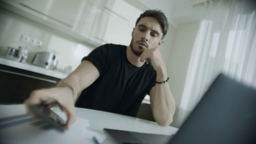

In [5]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

In [6]:
searches = "person",'dog','cat'
path = Path('person_dog_cat')

# for o in searches:
#     dest = (path/o)
#     dest.mkdir(exist_ok=True, parents=True)
#     download_images(dest, urls=search_images(f'{o} photo'))
#     resize_images(path/o, max_size=400, dest=path/o)

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

### Transforms

Use the albumentations library to perform two different types of image filters (to downscale the image quality):
* [Blur](https://albumentations.ai/docs/api_reference/full_reference/#albumentations.augmentations.transforms.Blur)
* [Downscale](https://albumentations.ai/docs/api_reference/full_reference/#albumentations.augmentations.transforms.Downscale)

In order to get the right parameters for these transforms, I used the [Streamlit app](https://albumentations-demo.herokuapp.com/) that allows your to see the output.

First we need to create a custom Transform

In [8]:
import albumentations as A

class AlbTransform(Transform):
    def __init__(self, aug): self.aug = aug
    def encodes(self, img: PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

# tfm = AlbTransform(A.Blur(blur_limit=(20,20), p=1))
# a,b = tfm((img, "person"))
# show_image(a, title=b);

In [174]:
blur = AlbTransform(A.Blur(blur_limit=(20,20), p=1))
downscale = AlbTransform(A.Downscale(always_apply=True, scale_min=0.1, scale_max=0.1, interpolation=3))

### Blur

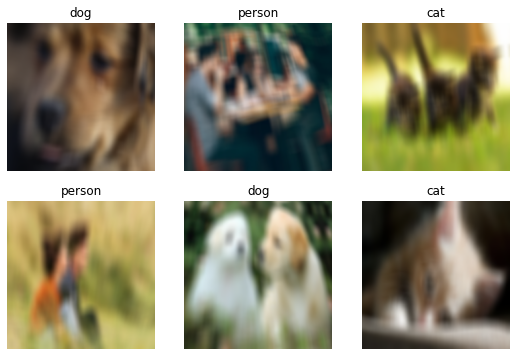

In [175]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[blur, Resize(224, method='squish')],
    batch_tfms=aug_transforms()
).dataloaders(path)

dls.show_batch(max_n=6)

We need to make sure that these transforms are applied to the validation data

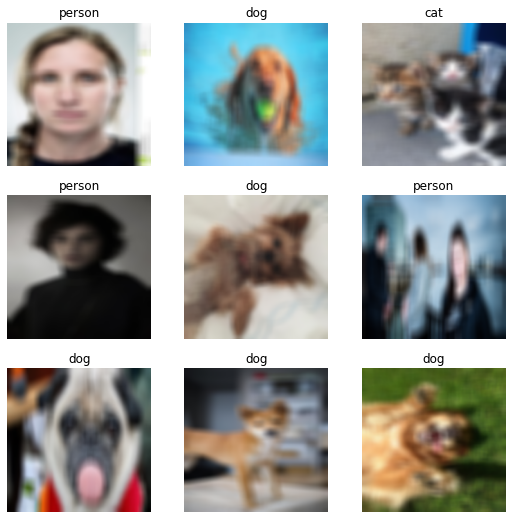

In [176]:
# dls[1].dataset.set_split_idx(0)
dls[1].show_batch()

We can try a couple of models - see appendix section on how we find the *tiny* models 

In [177]:
blur_learn = vision_learner(dls, "deit_tiny_patch16_224", metrics=error_rate)

In [178]:
blur_learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.643323,0.801733,0.292035,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.116338,0.669186,0.230089,00:04
1,0.992832,0.580699,0.194690,00:04
2,0.928959,0.522768,0.159292,00:04
3,0.814803,0.492130,0.159292,00:04
4,0.723447,0.476217,0.159292,00:04
5,0.649331,0.464862,0.150442,00:04
6,0.585791,0.452028,0.150442,00:04
7,0.532627,0.435493,0.150442,00:04
8,0.495010,0.430052,0.141593,00:04
9,0.465393,0.428942,0.141593,00:04


In [179]:
blur_learn.unfreeze()
blur_learn.freeze_to(-2)

In [180]:
blur_learn.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.294479,0.439127,0.115044,00:04
1,0.299258,0.602763,0.185841,00:04
2,0.319252,0.608905,0.230089,00:04
3,0.300808,0.423359,0.150442,00:04
4,0.279470,0.491656,0.159292,00:04
5,0.246826,0.631488,0.185841,00:04
6,0.228636,0.470130,0.115044,00:04
7,0.205746,0.400601,0.132743,00:04
8,0.183016,0.377757,0.123894,00:04
9,0.164164,0.376342,0.115044,00:04


In [181]:
blur_learn.unfreeze()
# blur_learn.freeze_to(-2)

In [182]:
blur_learn.fit_one_cycle(10, lr_max=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,0.042513,0.419177,0.132743,00:04
1,0.068904,0.559260,0.168142,00:04
2,0.098786,0.857745,0.230089,00:04
3,0.127667,0.581839,0.168142,00:04
4,0.151713,0.319088,0.106195,00:04
5,0.142025,0.435182,0.159292,00:04
6,0.125716,0.417557,0.150442,00:04
7,0.114356,0.490999,0.168142,00:04
8,0.105546,0.499440,0.141593,00:04
9,0.093576,0.483677,0.132743,00:04


In [183]:
blur_learn.fit_one_cycle(15, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.042361,0.481615,0.123894,00:04
1,0.042992,0.474748,0.132743,00:04
2,0.039247,0.456245,0.115044,00:04
3,0.039396,0.447323,0.106195,00:04
4,0.033891,0.467175,0.106195,00:04
5,0.029939,0.469003,0.106195,00:04
6,0.027763,0.469526,0.115044,00:04
7,0.026574,0.479521,0.115044,00:04
8,0.026066,0.491594,0.115044,00:04
9,0.025001,0.493386,0.115044,00:04


### Downscale

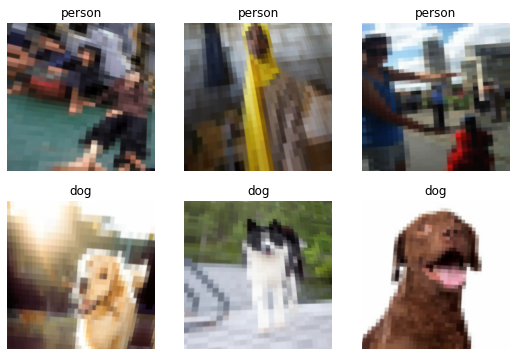

In [193]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[downscale, Resize(224, method='squish')],
    batch_tfms=aug_transforms()
).dataloaders(path)

dls.show_batch(max_n=6)

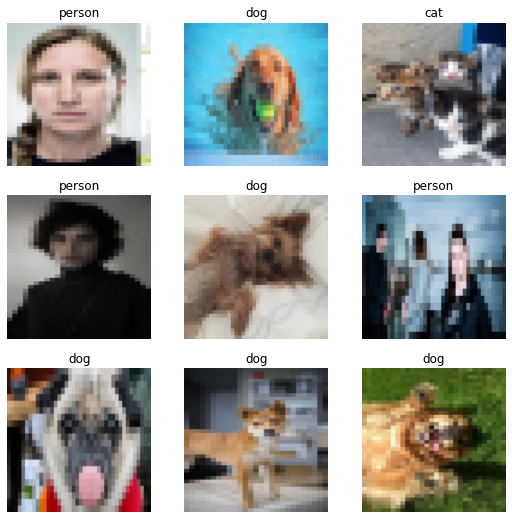

In [194]:
dls[1].show_batch()

In [195]:
downscale_learn = vision_learner(dls, "deit_tiny_patch16_224", metrics=error_rate)

In [196]:
downscale_learn.fine_tune(10, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.843037,1.091311,0.548673,00:04


epoch,train_loss,valid_loss,error_rate,time
0,1.467566,0.950696,0.486726,00:04
1,1.323597,0.858683,0.380531,00:04
2,1.239593,0.789310,0.327434,00:05
3,1.176678,0.810763,0.318584,00:04
4,1.119942,0.682093,0.283186,00:04
5,1.037753,0.640808,0.274336,00:04
6,0.954163,0.627087,0.265487,00:04
7,0.879154,0.645445,0.265487,00:04
8,0.835567,0.634394,0.274336,00:04
9,0.802554,0.647319,0.265487,00:04


In [197]:
downscale_learn.unfreeze()
downscale_learn.freeze_to(-2)

In [198]:
downscale_learn.fit_one_cycle(10, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.543624,0.645094,0.265487,00:04
1,0.549186,0.633144,0.256637,00:04
2,0.603437,0.578774,0.238938,00:04
3,0.577562,0.510453,0.238938,00:04
4,0.571037,0.481142,0.212389,00:04
5,0.554202,0.479897,0.203540,00:05
6,0.541147,0.490987,0.194690,00:04
7,0.525918,0.486609,0.203540,00:04
8,0.510616,0.484697,0.203540,00:04
9,0.502333,0.483174,0.203540,00:04


In [199]:
downscale_learn.unfreeze()
downscale_learn.freeze_to(-4)

In [200]:
downscale_learn.fit_one_cycle(10, lr_max=5e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.442562,0.451516,0.176991,00:04
1,0.449721,0.435416,0.185841,00:04
2,0.422973,0.436478,0.194690,00:04
3,0.399138,0.379390,0.168142,00:04
4,0.372680,0.362092,0.176991,00:04
5,0.355311,0.353536,0.132743,00:04
6,0.326759,0.402880,0.132743,00:04
7,0.303226,0.357993,0.159292,00:04
8,0.280136,0.344044,0.141593,00:04
9,0.257645,0.346915,0.141593,00:04


## Appendix

Which pretrained model is the smallest?

In [20]:
def learner_sz(learner):
    num_params = 0
    for layer in learner.model.parameters():
        num_params += layer.flatten().shape[0]
    return num_params

In [22]:
learner_sz(blur_learn)

6369316

In [37]:
model_path = Path("/root/.cache/torch/hub/checkpoints/")

In [56]:
models = []

for model in timm.list_models("*tiny*", pretrained=True):
    learner = vision_learner(dls, model, metrics=error_rate)
    models.append({"model": model, "sz": learner_sz(learner)})
    try:
        next(model_path.glob(f"{model}*")).unlink()
    except:
        continue

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-coat-weights/coat_lite_tiny-461b07a7.pth" to /root/.cache/torch/hub/checkpoints/coat_lite_tiny-461b07a7.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-coat-weights/coat_tiny-473c2a20.pth" to /root/.cache/torch/hub/checkpoints/coat_tiny-473c2a20.pth
Downloading: "https://dl.fbaipublicfiles.com/convit/convit_tiny.pth" to /root/.cache/torch/hub/checkpoints/convit_tiny.pth
Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_tiny_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny_1k_224_ema.pth
Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_distilled_patch16_224-b40b3cf7.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_distilled_patch16_224-b40b3cf7.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vt3p-weights/jx_nest_tiny-e3428fb9.pth" to /root/.cache/torch/hub/checkpoints/jx

In [57]:
models_df = pd.DataFrame(models)

In [63]:
models_df.sort_values("sz").to_csv("tiny_models.csv")

In [ ]:
models_df.sort_values("sz")